In [130]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from PIL import Image
import scipy.linalg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters
* size of original planet image
* ratio of occluder radius to occluded radius
* slope of occultation path
* intercept of occultation path
* lightcurve sampling rate
* blur radius due to occluder atmosphere

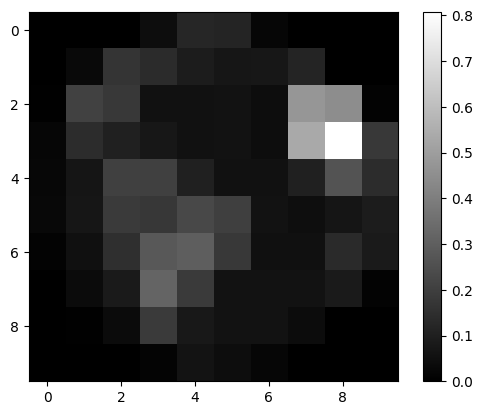

In [131]:
image_path = './figures/earth.jpg'
image = Image.open(image_path).convert('L')
image = image.resize((10, 10))
image_arr = np.expand_dims(np.array(image), axis=-1) / 255.
# image_arr = np.pad(image_arr, ((2, 2), (2, 2), (0, 0)))
plt.imshow(image_arr,cmap='gray')
plt.colorbar();

In [132]:
image_arr.shape

(10, 10, 1)

In [133]:
H, W = image_arr.shape[:2]

def pixel_coordinates(pixel_index, image_height, image_width):
    """Returns coordinates of upper-left vertex of pixel. Assumes image extent of (1, 1)."""
    if pixel_index >= (image_height * image_width):
        raise ValueError('Pixel index out of range.')
    row, col = np.unravel_index(pixel_index, (image_height, image_width), order='C')
    xmin = col / image_width
    ymin = row / image_height
    return xmin, ymin

In [134]:
def calculate_circle_pixel_overlap(circle_xc, circle_yc, circle_r, pixel_xmin, pixel_ymin, pixel_xmax, pixel_ymax, n_samples=50):
    """Calculates the percentage of the pixel covered by the circle.

    Args:
        circle_xc: x coordinate of circle center
        circle_yc: y coordinate of circle center
        circle_r: circle radius
        pixel_xmin: x coordinate of upper-left corner of pixel
        pixel_ymin: y coordinate of upper-left corner of pixel
        pixel_xmax: x coordinate of lower-right corner of pixel
        pixel_ymax: y coordinate of lower-right corner of pixel
        pixel_size: size of pixel in each direction
    """
    # Create a grid of sample points within the cell
    x_samples = np.linspace(pixel_xmin, pixel_xmax, n_samples)
    y_samples = np.linspace(pixel_ymin, pixel_ymax, n_samples)
    X, Y = np.meshgrid(x_samples, y_samples)

    # Calculate distance from each sample point to circle center
    distances = np.sqrt((X - circle_xc)**2 + (Y - circle_yc)**2)

    # Count points inside the circle
    points_inside = np.sum(distances <= circle_r)
    total_points = n_samples ** 2

    return points_inside / total_points

def pixel_weights(circle_xc, circle_yc, circle_r, image_height, image_width):
    n_pixels = image_height * image_width
    weights = np.ones(n_pixels)
    for pixel_index in range(n_pixels):
        pixel_xmin, pixel_ymin = pixel_coordinates(pixel_index, image_height, image_width)
        pixel_xmax = pixel_xmin + (1 / image_width)
        pixel_ymax = pixel_ymin + (1 / image_height)
        coverage_by_circle = calculate_circle_pixel_overlap(
            circle_xc, circle_yc, circle_r, pixel_xmin, pixel_ymin, pixel_xmax, pixel_ymax)
        weights[pixel_index] = 1 - coverage_by_circle
    return weights

In [135]:
def get_circle_center_coordinates(circle_r, path_slope, path_y_offset, n_time_samples, total_time=1, circle_velocity=10):
    dt = total_time / n_time_samples
    d = circle_velocity * dt  # distance traveled with each time step
    dx = d * np.cos(np.arctan(path_slope))  # x distance traveled with each time step
    dy = d * np.sin(np.arctan(path_slope))  # y distance traveled with each time step

    xc_init, yc_init = -circle_r, path_y_offset
    def _circle_coordinates(t):
        """Returns the coordinates of the circle center at time t."""
        xc = xc_init + (t / dt) * dx
        yc = yc_init + (t / dt) * dy
        return xc, yc

    times = np.linspace(0, total_time, n_time_samples)
    x_coordinates = np.zeros(n_time_samples)
    y_coordinates = np.zeros(n_time_samples)
    for t_index, t in enumerate(times):
        xc, yc = _circle_coordinates(t)
        x_coordinates[t_index] = xc
        y_coordinates[t_index] = yc
    return x_coordinates, y_coordinates

In [136]:
def get_weights_matrix(circle_x_coordinates, circle_y_coordinates, circle_r, image_height, image_width):
    """Returns the function for computing the circle's location at a given time.

    Args:
        circle_r: circle radius
        path_slope: slope of the path the occluding circle takes
        path_y_offset: offset applied to initial y coordinate of circle center,
                       assuming a starting point of (-circle_r, -circle_r + path_y_offset)
        circle_velocity: velocity of the circle
        total_time: total duration of the observation
        n_time_samples: number of evenly-spaced samples throughout the observation
    """
    # Construct rendering matrix
    n_time_samples = len(circle_x_coordinates)
    n_pixels = image_height * image_width
    A = np.zeros((n_time_samples, n_pixels))

    for t_index in range(n_time_samples):
        xc = circle_x_coordinates[t_index]
        yc = circle_y_coordinates[t_index]
        weights = pixel_weights(xc, yc, circle_r, image_height, image_width)
        A[t_index] = weights

    return A

In [137]:
circle_r = 1
xcs, ycs = get_circle_center_coordinates(circle_r=circle_r, path_slope=0., path_y_offset=0.25, n_time_samples=100, total_time=3, circle_velocity=1)
A = get_weights_matrix(xcs, ycs, circle_r=circle_r, image_height=H, image_width=W)

In [138]:
A.shape

(100, 100)

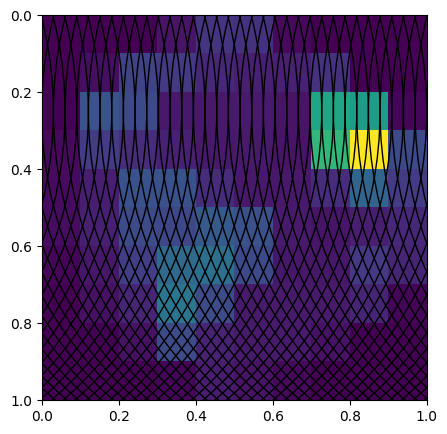

In [139]:
# Create a figure. Equal aspect so circles look circular
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Show the image
ax.imshow(image_arr, extent=(0, 1, 1, 0))

for xc, yc in zip(xcs, ycs):
    circ = Circle((xc, yc), circle_r, fill=False)
    ax.add_patch(circ)

plt.show()

In [140]:
def visualize_history(history, num_timesteps=50, matrix_size=10, save_animation=False):
    """
    Visualize the weight matrix evolution over time.

    Args:
        history: Tensor of shape (num_timesteps, matrix_size, matrix_size)
        num_timesteps: Number of timesteps
        matrix_size: Size of the matrix
        save_animation: If True, save an animated gif
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))

    # Plot 1: Grid of selected timesteps (top half)
    # Select key timesteps to display (every 5th timestep for 10 total)
    selected_timesteps = np.linspace(0, num_timesteps - 1, 10, dtype=int)
    cols = 5
    rows = 2

    # Create a grid for the timestep snapshots
    gs = fig.add_gridspec(3, 1, hspace=0.3, height_ratios=[1.2, 1, 1])

    # Top section: timestep snapshots
    ax_top = fig.add_subplot(gs[0])
    ax_top.axis('off')
    ax_top.set_title('Weight Matrix Evolution - Selected Timesteps',
                     fontsize=14, fontweight='bold', pad=20)

    # Create subplots for each timestep
    inner_grid = fig.add_gridspec(rows, cols, left=0.05, right=0.95,
                                   top=0.95, bottom=0.7, hspace=0.3, wspace=0.3)

    for idx, t in enumerate(selected_timesteps):
        ax = fig.add_subplot(inner_grid[idx // cols, idx % cols])
        im = ax.imshow(history[t], cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
        ax.set_title(f't={t}', fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
        if idx == 0:
            ax.set_ylabel('Row', fontsize=8)
        if idx >= 5:
            ax.set_xlabel('Col', fontsize=8)

    # Add colorbar for timestep snapshots
    cbar = fig.colorbar(im, ax=ax_top, orientation='horizontal',
                        pad=0.05, aspect=30, shrink=0.8)
    cbar.set_label('Weight (1=uncovered, 0=covered)', fontsize=9)

    # Plot 2: Mean weight over time
    ax2 = fig.add_subplot(gs[1])
    mean_weights = np.mean(history, axis=(1, 2))
    ax2.plot(mean_weights, linewidth=2, color='blue')
    ax2.set_xlabel('Timestep', fontsize=11)
    ax2.set_ylabel('Mean Weight', fontsize=11)
    ax2.set_title('Mean Weight Over Time', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.1])

    # Plot 3: Weight distribution at equator over time
    ax3 = fig.add_subplot(gs[2])
    equator_row = matrix_size // 2
    equator_weights = history[:, equator_row, :]  # Shape: (timesteps, width)

    im3 = ax3.imshow(equator_weights.T, cmap='RdYlGn', aspect='auto',
                     origin='lower', vmin=0, vmax=1, interpolation='bilinear')
    ax3.set_xlabel('Timestep', fontsize=11)
    ax3.set_ylabel('Column (along equator)', fontsize=11)
    ax3.set_title('Weight Evolution at Equator Row', fontsize=12, fontweight='bold')
    cbar3 = plt.colorbar(im3, ax=ax3)
    cbar3.set_label('Weight', fontsize=9)

    plt.tight_layout()
    plt.savefig('weights_evolution.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved as 'weights_evolution.png'")
    plt.show()

    # Optional: Create animation
    if save_animation:
        print("\nCreating animation...")
        fig_anim, ax_anim = plt.subplots(figsize=(8, 8))

        # Create initial image and colorbar (only once)
        im_anim = ax_anim.imshow(history[0], cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
        ax_anim.set_title(f'Timestep 0/{num_timesteps - 1}', fontsize=14, fontweight='bold')
        ax_anim.set_xlabel('Column', fontsize=11)
        ax_anim.set_ylabel('Row', fontsize=11)
        cbar_anim = plt.colorbar(im_anim, ax=ax_anim, label='Weight (1=uncovered, 0=covered)')

        def animate(frame):
            # Only update the image data, don't recreate everything
            im_anim.set_array(history[frame])
            ax_anim.set_title(f'Timestep {frame+1}/{num_timesteps}', fontsize=14, fontweight='bold')
            return [im_anim]

        anim = FuncAnimation(fig_anim, animate, frames=num_timesteps,
                            interval=100, blit=True, repeat=True)
        anim.save('weights_animation.gif', writer='pillow', fps=10)
        print("Animation saved as 'weights_animation.gif'")
        plt.close(fig_anim)

/var/folders/qq/_c3h3m7x0cj6f8qprnj5kyjw0000gq/T/ipykernel_66297/3623669272.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Visualization saved as 'weights_evolution.png'


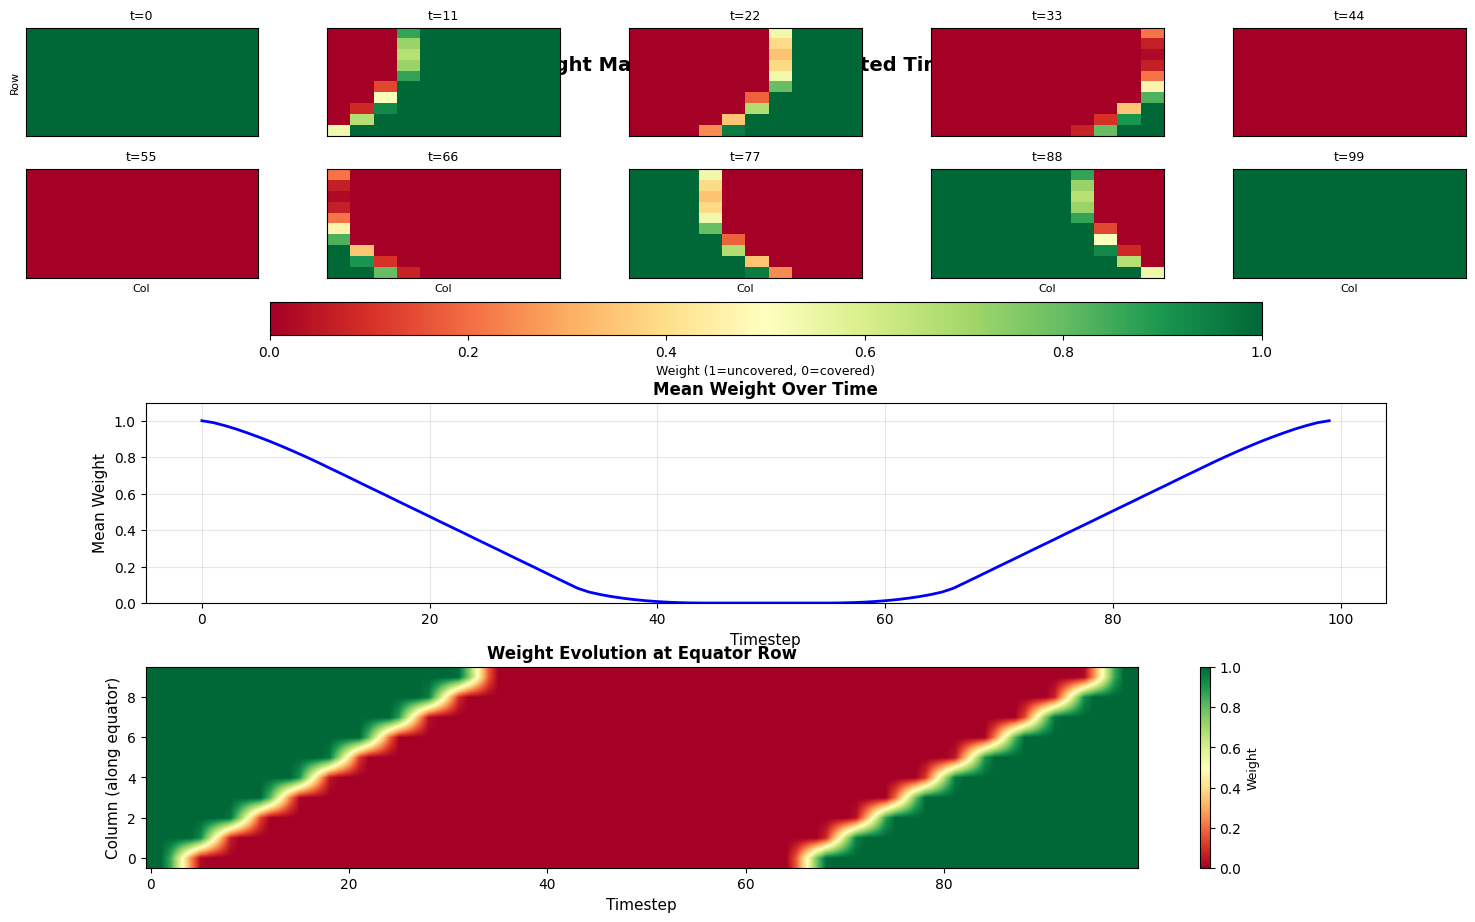

In [141]:
visualize_history(A.reshape(100,10,10),num_timesteps=100,save_animation=False)

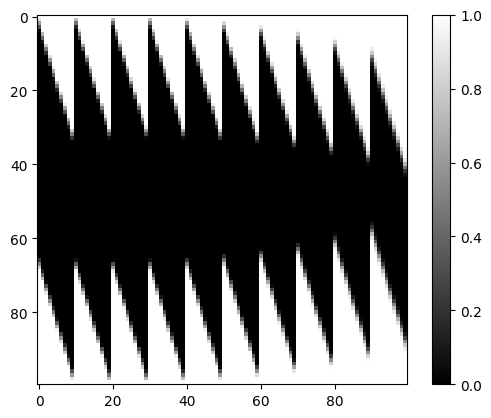

In [142]:
plt.imshow(A, cmap='gray')
plt.colorbar();

In [143]:
def generate_mu(image_size_pixels=10, fov_fraction=0.3):
    """
    Generates the mu image (circular Gaussian mean) described in the paper.

    Args:
        image_size_pixels (int): The width/height of the square image in pixels.
        fov_fraction (float): The standard deviation of the Gaussian as a fraction
                              of the total Field of View (width of the image).
                              The paper suggests 40-50% (0.4-0.5).

    Returns:
        numpy.ndarray: The 2D Gaussian image array.
    """

    # 1. Create a coordinate grid centered at (0,0)
    # We define the FOV as going from -0.5 to 0.5 (total width = 1.0 unit)
    x = np.linspace(-0.5, 0.5, image_size_pixels)
    y = np.linspace(-0.5, 0.5, image_size_pixels)
    X, Y = np.meshgrid(x, y)

    # 2. Define the standard deviation (sigma) based on the paper's specs
    # "Standard deviation of 40-50% of the reconstructed FOV"
    sigma = fov_fraction  # e.g., 0.45 corresponds to 45% of the total width

    # 3. Calculate the 2D Circular Gaussian function
    # formula: exp( - (x^2 + y^2) / (2 * sigma^2) )
    mu = np.exp(-(X**2 + Y**2) / (2 * sigma**2))

    return mu

In [144]:
def get_dft_matrix(image_size):
    """Returns the DFT operator matrix.
    Args:
    image_size: Height = width the image.
    dft_comps: A 1D array containing the indices of the rows of the full DFT
      matrix to keep.
    Returns:
    A 2D array representing the DFT measurement matrix, where only the rows
      corresponding to `dft_comps` are kept. The first half of the rows
      corresponds to the real part of the measurements, while the second
      half of the rows corresponds to the imaginary part.
    """
    dft_matrix_1d = scipy.linalg.dft(image_size)
    dft_matrix = np.kron(dft_matrix_1d, dft_matrix_1d)
    return dft_matrix
  # Split matrix into real and imaginary submatrices.
  # dft_matrix_expanded = np.concatenate(
  #     (dft_matrix.real, dft_matrix.imag), axis=0)
  # return dft_matrix_expanded

In [145]:
def genFreqComp(image_width, image_height):
    x_psize = 1 / image_width
    y_psize = 1 / image_height
    fN2 = int(np.floor(image_width/2)) #TODO: !!! THIS DOESNT WORK FOR ODD IMAGE SIZES
    fM2 = int(np.floor(image_height/2))

    ulist = (np.array([np.concatenate((np.linspace(0, fN2 - 1, fN2), np.linspace(-fN2, -1, fN2)), axis=0)])  / image_width ) / x_psize
    vlist = (np.array([np.concatenate((np.linspace(0, fM2 - 1, fM2), np.linspace(-fM2, -1, fM2)), axis=0)])  / image_height ) / y_psize

    ufull, vfull = np.meshgrid(ulist, vlist)

    # ufull = np.reshape(ufull, (im.xdim*im.ydim, -1), order='F')
    # vfull = np.reshape(vfull, (im.xdim*im.ydim, -1), order='F')
    ufull = np.reshape(ufull, (image_width*image_height, -1))
    vfull = np.reshape(vfull, (image_width*image_height, -1))

    return (ufull, vfull)

In [146]:
mu = generate_mu()
W = get_dft_matrix(10)

In [147]:
eps = 1e-3
ufull, vfull = genFreqComp(10, 10)
uvdist = np.reshape( np.sqrt(ufull**2 + vfull**2), (ufull.shape[0]) ) + eps
uvdist = uvdist / np.min(uvdist)
uvdist[0] = np.inf

In [148]:
a = 2
imCov_prime = np.dot( np.transpose(np.conj(W)) , np.dot( np.diag( 1/(uvdist**a) ), W ) )

In [149]:
frac = 1/3
imCov = frac**2 * np.dot( np.diag(mu.reshape(-1)).T, np.dot(imCov_prime/imCov_prime[0,0], np.diag(mu.reshape(-1)) ) )

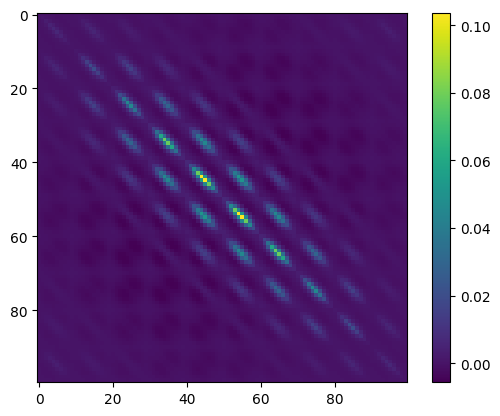

In [150]:
plt.imshow(imCov.real)
plt.colorbar();

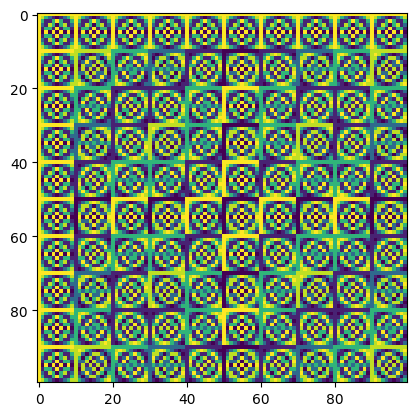

In [151]:
plt.imshow(W.real);

In [152]:
def generate_R_matrix(num_measurements, sigma):
    """
    Generate the R matrix (Noise Covariance Matrix) for the inverse problem.

    As per Equation 9 in Bouman et al. (2018):
    R = diag[sigma[1]^2, ..., sigma[K]^2]

    If we assume isotropic noise (same noise level for all measurements),
    then R is a scaled identity matrix where the scalar is the VARIANCE (sigma^2).

    Args:
        num_measurements (int): The number of measurements (length of vector y).
        sigma (float): The standard deviation of the Gaussian noise.

    Returns:
        numpy.ndarray: The R covariance matrix of size (num_measurements, num_measurements).
    """
    # The diagonal elements must be variance (sigma squared)
    variance = sigma ** 2

    # Create diagonal matrix
    R = np.eye(num_measurements) * variance

    return R

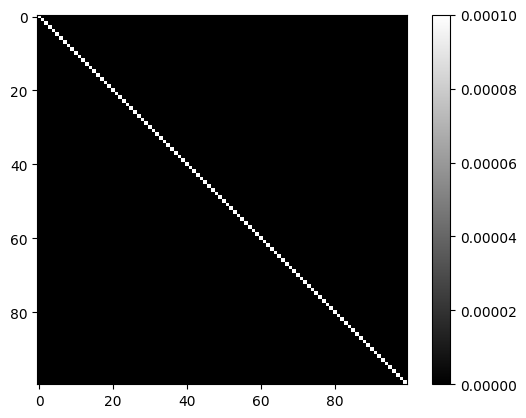

In [185]:
R=generate_R_matrix(100,0.01)
plt.imshow(R,cmap='gray')
# plt.clim(0, 0.001)
plt.colorbar();

In [154]:
mu.shape, imCov.shape, A.shape, R.shape

((10, 10), (100, 100), (100, 100), (10, 10))

In [155]:
mu.min(), mu.max(), A.min(), A.max()

(np.float64(0.06217652402211632),
 np.float64(0.966287806496483),
 np.float64(0.0),
 np.float64(1.0))

In [202]:
y = np.loadtxt('outputs/lightcurve.csv', delimiter=',')
y=y[0].shape
A = np.loadtxt('outputs/weights_matrix.csv', delimiter=',')
print(A.shape)
A_round=np.round(A,3)
mu_round=np.round(mu,3)


(100, 100)


/var/folders/qq/_c3h3m7x0cj6f8qprnj5kyjw0000gq/T/ipykernel_66297/3505583500.py:2: RuntimeWarning: divide by zero encountered in matmul
  FLF=np.matmul(A_round,np.matmul(imCov,np.transpose(A_round)))
/var/folders/qq/_c3h3m7x0cj6f8qprnj5kyjw0000gq/T/ipykernel_66297/3505583500.py:2: RuntimeWarning: overflow encountered in matmul
  FLF=np.matmul(A_round,np.matmul(imCov,np.transpose(A_round)))
/var/folders/qq/_c3h3m7x0cj6f8qprnj5kyjw0000gq/T/ipykernel_66297/3505583500.py:2: RuntimeWarning: invalid value encountered in matmul
  FLF=np.matmul(A_round,np.matmul(imCov,np.transpose(A_round)))


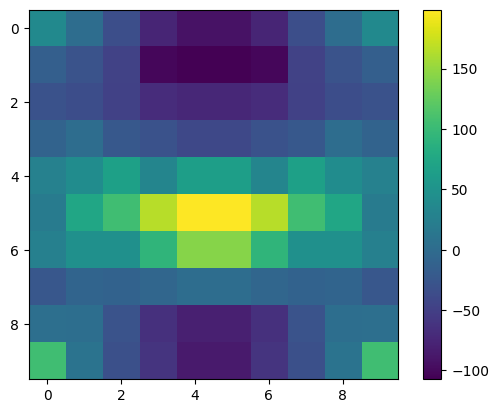

In [204]:
yFmu=(y-np.dot(A_round,mu_round.reshape(-1)))
FLF=np.matmul(A_round,np.matmul(imCov,np.transpose(A_round)))
RFLF=R+FLF
invRFLF=np.linalg.pinv(RFLF)
innovation = np.dot(invRFLF, yFmu)
second_term = np.dot(imCov,np.dot(np.transpose(A_round), innovation))
x_hat=mu_round.reshape(-1)+second_term
x_hat = np.reshape(x_hat, (10, 10))
plt.imshow(np.real(x_hat))
plt.colorbar();